# Prepare SST dataset for comparison with CESM-LE

[Optimum Interpolation Sea Surface Temperature (OISST) v2.1](https://www.ncdc.noaa.gov/oisst/optimum-interpolation-sea-surface-temperature-oisst-v21)

The NOAA 1/4° daily Optimum Interpolation Sea Surface Temperature (or daily OISST) is an analysis constructed by combining observations from different platforms (satellites, ships, buoys and Argo floats) on a regular global grid. A spatially complete SST map is produced by interpolating to fill in gaps. The methodology includes bias adjustment of satellite and ship observations (referenced to buoys) to compensate for platform differences and sensor biases. This proved critical during the Mt. Pinatubo eruption in 1991, when the widespread presence of volcanic aerosols resulted in infrared satellite temperatures that were much cooler than actual ocean temperatures (Reynolds 1993). Starting from April 1, 2020, NCEI released a new version, OISST v2.1, to replace OISST v2. OISST v2 had been stopped on April 26, 2020 due to unavailable input data to it.

Currently OISST v2.1 data are available from Sept 1, 1981 onward and updated nominally daily. The new version has significant quality improvement for data starting from January 1, 2016 onward - see below for more details. For the data from September 1981 to December 2015, data for SST and SST anomaly are the same as v2 but format was updated from netCDF3 to netCDF4 with updated metadata in v2.1. 


This notebook does the following operations:

1. Download daily data via HTTP protocol from [here](https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr).

1. Compute monthly means from daily data.

1. Regrid monthly data from 1/4° native grid to the POP `gx1v6` grid. This has a few steps:
    - Generate SCRIP grid files for source and destination grids;
    - Use ESMF tool box to generate remapping weights;
    - Apply remapping weights.
    
1. Assemble remapped monthly data into a single file subsetted for the Southern Ocean domain.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob
import subprocess
import urllib
import calendar
from datetime import datetime
import tqdm

import numpy as np

import dask
import xarray as xr

import pop_tools

import util

Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [3]:
clobber = False
dst_grid = 'POP_gx1v6'

FILE_OUT = f'{util.project_tmpdir}/HadISST_DJF.{dst_grid}.zarr'
FILE_OUT    

'/glade/p/cgd/oce/projects/krill-cesm-le/data/HadISST_DJF.POP_gx1v6.zarr'

## Setup regridding machinery

Make SCRIP grid file for source grid.

In [4]:
gridfile_directory = f'{util.project_tmpdir}/regrid'
os.makedirs(gridfile_directory, exist_ok=True)

In [5]:
src_grid = 'latlon_1x1_lon180'
src_grid_file = f'{gridfile_directory}/{src_grid}.nc'

if not os.path.exists(src_grid_file) or clobber:
    dso = util.latlon_to_scrip(
        nx=360, 
        ny=180, 
        lon0=-180., 
        file_out=src_grid_file,
    )

writing /glade/p/cgd/oce/projects/krill-cesm-le/data/regrid/latlon_1x1_lon180.nc


Make SCRIP grid file for ocean model grid.

In [6]:
dst_grid_file= f'{gridfile_directory}/{dst_grid}.nc'

if not os.path.exists(dst_grid_file) or clobber:
    dso = pop_tools.get_grid('POP_gx1v6', scrip=True)
    del dso.attrs['region_mask_regions']
    print(f'writing {dst_grid_file}')
    dso.to_netcdf(dst_grid_file)

Call `ESMF_RegridWeightGen` to generate weight file.

In [7]:
%%time
method = 'conserve'
weight_file = f'{gridfile_directory}/{src_grid}_to_{dst_grid}_{method}.nc'

if not os.path.exists(weight_file) or clobber:
    cmd = ['ESMF_RegridWeightGen', '--netcdf4', '--ignore_unmapped',
                '-s', src_grid_file, '-d', dst_grid_file, '-m', method, '-w', weight_file]
    out = subprocess.run(cmd, capture_output=True, check=True)
    print(out.stdout.decode('UTF-8'))

 Starting weight generation with these inputs: 
   Source File: /glade/p/cgd/oce/projects/krill-cesm-le/data/regrid/latlon_1x1_lon180.nc
   Destination File: /glade/p/cgd/oce/projects/krill-cesm-le/data/regrid/POP_gx1v6.nc
   Weight File: /glade/p/cgd/oce/projects/krill-cesm-le/data/regrid/latlon_1x1_lon180_to_POP_gx1v6_conserve.nc
   Source File is in SCRIP format
   Source Grid is a global grid
   Source Grid is a logically rectangular grid
   Use the center coordinates of the source grid to do the regrid
   Destination File is in SCRIP format
   Destination Grid is a global grid
   Destination Grid is a logically rectangular grid
   Use the center coordinates of the destination grid to do the regrid
   Regrid Method: conserve
   Pole option: NONE
   Ignore unmapped destination points
   Output weight file in NetCDF4 file format
   Line Type: greatcircle
   Norm Type: dstarea
   Extrap. Method: none

 Completed weight generation successfully.


CPU times: user 138 µs, sys: 7.18 ms, t

Set up remapping operator

In [9]:
regrid_op = util.regridder(src_grid_file, dst_grid_file, weight_file)
regrid_op

source grid dims: (180, 360)
destination grid dims: (384, 320)


regridder latlon_1x1_lon180.nc --> POP_gx1v6.nc

## Download and process files

Set up some directories and xarray option for reading files.

In [10]:
dirloc = f'{util.project_tmpdir}/HadISST'
dirtmp = f'/glade/work/{os.environ["USER"]}/HadISST'
os.makedirs(dirloc, exist_ok=True)
os.makedirs(dirtmp, exist_ok=True)

Define a function for computing monthly means from daily files.

In [25]:
os.getcwd()

'/glade/u/home/mclong/p/krill-cesm-le/notebooks'

In [50]:
f_local = f'{dirtmp}/HadISST_sst.nc'
if not os.path.exists(f_local):
    cwd = os.getcwd()
    os.chdir(dirtmp)
    url = 'https://www.metoffice.gov.uk/hadobs/hadisst/data/HadISST_sst.nc.gz'
    subprocess.run(['wget', url])
    subprocess.run(['gunzip', 'HadISST_sst.nc.gz'])
    os.chdir(cwd)

ds_in = xr.open_dataset(f_local, decode_times=False, decode_coords=False)
ds_in.time.attrs['bounds'] = 'time_bnds'
ds_in

<xarray.Dataset>
Dimensions:    (latitude: 180, longitude: 360, nv: 2, time: 1804)
Coordinates:
  * time       (time) float32 15.499994 44.999992 74.49999 ... 54861.5 54892.5
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 ...
    sst        (time, latitude, longitude) float32 ...
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    10/6/2020 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

In [51]:
%%time
ds = xr.Dataset({'time': ds_in.time, 'time_bnds': ds_in.time_bnds})
ds['sst'] = regrid_op.regrid_dataarray(
            ds_in.sst[:, ::-1, :], # latitude is upside down 
            renormalize=True, 
            apply_mask=True,
)

ds.attrs = ds_in.attrs

ds = ds.rename(latitude='nlat', longitude='nlon')

time_bnds = ds[ds.time.bounds]
ds = xr.decode_cf(ds.drop(ds.time.bounds), decode_times=True, use_cftime=True)
ds['time_bnds'] = time_bnds.assign_coords(time=ds.time)

pop_grid = pop_tools.get_grid('POP_gx1v6')[['TLAT', 'TLONG', 'KMT', 'TAREA']]
ds = xr.merge((ds, pop_grid))
ds

CPU times: user 4.94 s, sys: 6.55 s, total: 11.5 s
Wall time: 11.4 s


<xarray.Dataset>
Dimensions:    (nlat: 384, nlon: 320, nv: 2, time: 1804)
Coordinates:
  * time       (time) object 1870-01-16 11:59:59.505615 ... 2020-04-16 12:00:00
Dimensions without coordinates: nlat, nlon, nv
Data variables:
    sst        (time, nlat, nlon) float64 ...
    time_bnds  (time, nv) float32 0.0 30.999989 31.0 ... 54877.0 54877.0 54908.0
    TLAT       (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG      (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    KMT        (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    TAREA      (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12

In [52]:
%%time
ds_djf = util.ann_mean(ds, season='DJF')

CPU times: user 18.3 s, sys: 10.8 s, total: 29.1 s
Wall time: 29.1 s


In [53]:
util.write_ds_out(ds_djf, FILE_OUT)

------------------------------
Writing /glade/p/cgd/oce/projects/krill-cesm-le/data/HadISST_DJF.POP_gx1v6.zarr
xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 320 ;
	time = 150 ;

variables:
	float64 sst(time, nlat, nlon) ;
		sst:standard_name = sea_surface_temperature ;
		sst:long_name = sst ;
		sst:units = C ;
		sst:cell_methods = time: lat: lon: mean ;
	float64 TLAT(time, nlat, nlon) ;
		TLAT:units = degrees_north ;
		TLAT:long_name = T-grid latitude ;
	float64 TLONG(time, nlat, nlon) ;
		TLONG:units = degrees_east ;
		TLONG:long_name = T-grid longitude ;
	float64 KMT(time, nlat, nlon) ;
		KMT:long_name = k Index of Deepest Grid Cell on T Grid ;
		KMT:coordinates = TLONG TLAT ;
	float64 TAREA(time, nlat, nlon) ;
		TAREA:units = cm^2 ;
		TAREA:long_name = area of T cells ;
		TAREA:coordinates = TLONG TLAT ;
	int64 time(time) ;

// global attributes:
}


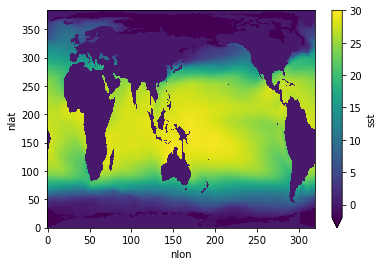

In [54]:
ds_djf.sst.mean('time').plot(vmin=-2, vmax=30)

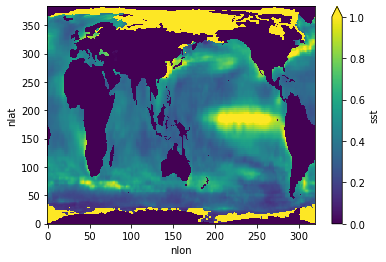

In [55]:
ds_djf.sst.std('time').plot(vmin=0, vmax=1)